จัดการ Missing Values เสร็จสิ้น: เติมด้วยค่าเฉลี่ยของคอลัมน์
Input (X): ['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium', 'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280']
Output (y): Proline
จำนวนข้อมูล: Train = 142, Test = 36

SVR Results:
Best Parameters: {'C': 200, 'epsilon': 0.01, 'gamma': 'scale'}
MSE: 25684.567063511127 R²: 0.7974086445202612

KNN Results:
Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
MSE: 29285.341686310854 R²: 0.7690069272631154


C:\Users\opal_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\opal_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\opal_\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\opal_\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\opal_\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
  


Cluster Assignments (ตัวอย่าง 5 รายการแรก): [1 1 2 1 0]


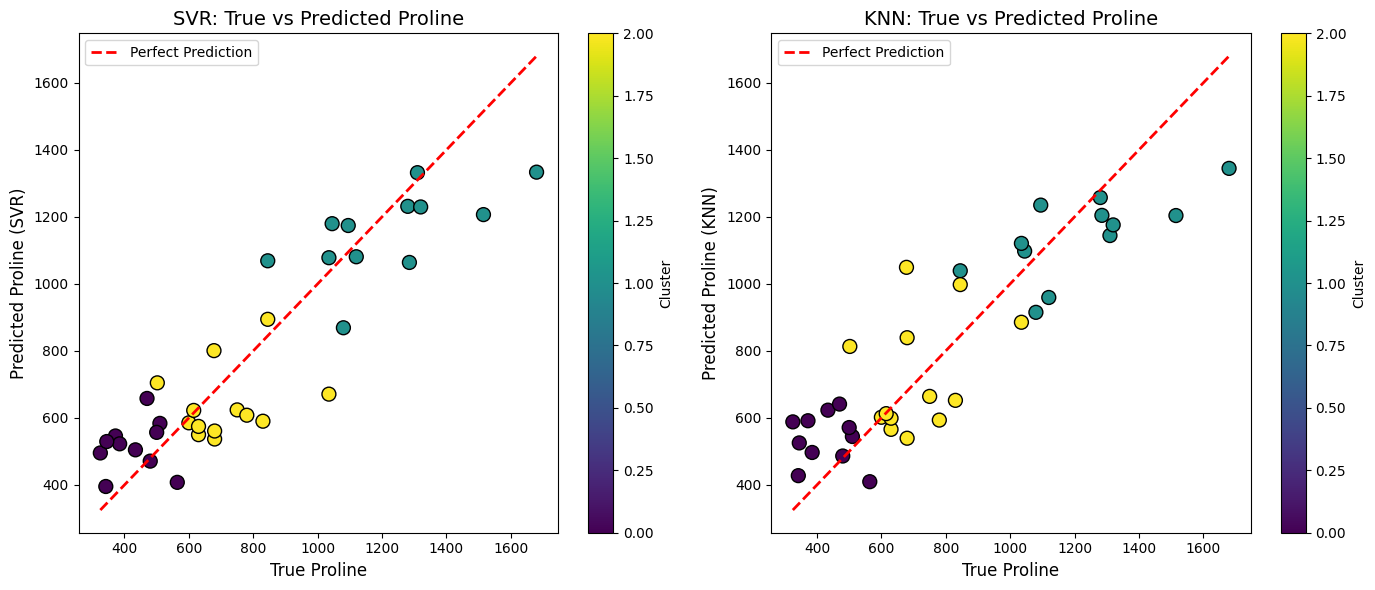


บันทึกโมเดลและ scaler เรียบร้อยแล้ว


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle

# 1. ดึงข้อมูลจากไฟล์ CSV
data = pd.read_csv('wine-clustering.csv')  # เปลี่ยนชื่อไฟล์ตามที่คุณบันทึก

# 2. จัดการ Missing Values
data = data.fillna(data.mean())
print("จัดการ Missing Values เสร็จสิ้น: เติมด้วยค่าเฉลี่ยของคอลัมน์")

# 3. กำหนด Input และ Output
X = data.drop(columns=['Proline'])  # Input: 12 ฟีเจอร์
y = data['Proline']  # Output: Proline
print("Input (X):", X.columns.tolist())
print("Output (y): Proline")

# 4. แยกชุดข้อมูล train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"จำนวนข้อมูล: Train = {len(X_train)}, Test = {len(X_test)}")

# 5. ปรับสเกลข้อมูล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. SVR
svr = SVR(kernel='rbf')
param_grid_svr = {'C': [50, 100, 200], 'epsilon': [0.01, 0.1], 'gamma': ['scale', 0.01, 0.1]}
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train)
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)
print("\nSVR Results:")
print("Best Parameters:", grid_search_svr.best_params_)
print("MSE:", svr_mse, "R²:", svr_r2)

# 7. KNN
knn = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)
print("\nKNN Results:")
print("Best Parameters:", grid_search_knn.best_params_)
print("MSE:", knn_mse, "R²:", knn_r2)

# 8. จัดกลุ่มด้วย KMeans
y_combined = np.column_stack((y_test, y_pred_svr, y_pred_knn))
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(y_combined)
print("\nCluster Assignments (ตัวอย่าง 5 รายการแรก):", clusters[:5])

# 9. แสดงกราฟสวยงาม
plt.figure(figsize=(14, 6))

# กราฟ SVR
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_test, y_pred_svr, c=clusters, cmap='viridis', edgecolor='k', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Proline', fontsize=12)
plt.ylabel('Predicted Proline (SVR)', fontsize=12)
plt.title('SVR: True vs Predicted Proline', fontsize=14)
plt.legend()
plt.colorbar(scatter, label='Cluster')

# กราฟ KNN
plt.subplot(1, 2, 2)
scatter = plt.scatter(y_test, y_pred_knn, c=clusters, cmap='viridis', edgecolor='k', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Proline', fontsize=12)
plt.ylabel('Predicted Proline (KNN)', fontsize=12)
plt.title('KNN: True vs Predicted Proline', fontsize=14)
plt.legend()
plt.colorbar(scatter, label='Cluster')

plt.tight_layout()
plt.show()

# 10. บันทึกโมเดลและ scaler
with open('svr_model_new.pkl', 'wb') as f:
    pickle.dump(best_svr, f)
with open('knn_model_new.pkl', 'wb') as f:
    pickle.dump(best_knn, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nบันทึกโมเดลและ scaler เรียบร้อยแล้ว")